In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#plotting

def plot_synthetic_landscapes(xi_all, pi_all, e_all, pi_all_out, box_min, box_max, minima_coords, plot_p=False, plot_e=False, plot_e_out=False, plot_hist=False, plot_states=False):
    
    if plot_p:
        if plot_hist:
            plt.hist2d([i[0] for i in xi_all], [i[1] for i in xi_all], weights = pi_all, bins = [40,40], range=[[box_min[0],box_max[0]],[box_min[1],box_max[1]]])
            for mc in minima_coords:
                plt.scatter(mc[0], mc[1])
            plt.axis("equal")
            plt.show()

        if plot_states:
            plt.scatter([i[0] for i in xi_all], [i[1] for i in xi_all], c=pi_all, cmap='viridis')
            plt.axis("equal")
            plt.show()

    if plot_e:
        #histograms of energies are a bad idea because adding positive energies makes the state appear higher in energy when it is actually lower
        # if plot_hist:
        #     plt.hist2d([i[0] for i in xi_all], [i[1] for i in xi_all], weights = e_all, bins = [40,40], range=[[box_min[0],box_max[0]],[box_min[1],box_max[1]]])
        #     for mc in minima_coords:
        #         plt.scatter(mc[0], mc[1])
        #     plt.axis("equal")
        #     plt.show()

        if plot_states:
            plt.scatter([i[0] for i in xi_all], [i[1] for i in xi_all], c=e_all, cmap='viridis')
            plt.axis("equal")
            plt.show()
    
    if plot_e_out:
        if plot_hist:
            plt.hist2d([i[0] for i in xi_all], [i[1] for i in xi_all], weights = pi_all_out, bins = [40,40], range=[[box_min[0],box_max[0]],[box_min[1],box_max[1]]])
            for mc in minima_coords:
                plt.scatter(mc[0], mc[1])
            plt.axis("equal")
            plt.show()

        if plot_states:
            plt.scatter([i[0] for i in xi_all], [i[1] for i in xi_all], c=pi_all_out, cmap='viridis')
            plt.axis("equal")
            plt.show()

In [3]:

#build an energy landscape with a specified set of minima, and transition states.
        #this landscape is to be represented by a set of points placed randomly in n-dimensional space at the specified state_density
        #temperature is used to construct the transition probability matrix (it should cancel out elsewhere? <--TODO verify this)
        #noise spectrum is the amplitude of noise to apply as a function of the spatial frequency of the noise (i.e. a low frequency noise is applied with wide gaussians)
def build_landscape(n_dim, minima_coords, minima_energies, state_density, kT, threshold, min_spacing, noise_spectrum):

    #select box dimensions that will include the whole of the relevant landscape
    mc_max = []
    mc_min = []

    #find dimensions that will extend 3 standard deviations from the bottom of each well
    for mci, mei in zip(minima_coords, minima_energies):
        mc_min.append([mcij-3*mei[1] for mcij in mci])
        mc_max.append([mcij+3*mei[1] for mcij in mci])

    box_min = np.min(mc_min, axis=0)
    box_max = np.max(mc_max, axis=0)

    box_lengths = box_max-box_min
    box_vol = np.prod(box_lengths)

    #obtain initial population estimates using the minima provided
    pi_all = []
    xi_all = []

    for point in range(state_density*box_vol):
        #sample uniformly distributed random coordinates within the box
        xi = np.multiply(box_lengths, np.random.rand(n_dim)) + box_min
        
        #keep only coordinates that are sufficiently far from existing ones since a more uniform distribution is a more efficient representation of configuration space
        #note that this creates surfaces slightly denser than the interior of the populated regions because there are no neighbors on one side which could be below the spacing threshold
        #but avoiding this would be expensive and it probably doesn't matter, to paraphrase the last words of many unfortunate souls.
        if len(xi_all) > 0:
            #print(np.stack(xi_all))
            #print(np.stack([xi for l in range(len(xi_all))], axis=0))
            dists_to_existing = np.linalg.norm(np.stack([xi for l in range(len(xi_all))], axis=0) - np.stack(xi_all), axis=1)
            if np.min(dists_to_existing) < min_spacing:
                point -= 1
                continue

        #count up total probability at current coordinates from all of the harmonic wells provided as arguments
        pi = 0
        for mc, me in zip(minima_coords, minima_energies):
            pi += np.exp(-(me[0] + (np.linalg.norm(mc-xi) / me[1]**(1/n_dim))**2))

        #discard nearly empty wells to save time
        if pi >= threshold:
            xi_all.append(xi)
            pi_all.append(pi)

    #normalize probabilities
    p_tot = sum(pi_all)
    pi_all = [pii/p_tot for pii in pi_all]
    
    #calculate energies and then determine populations at a temperature differing by a factor of kT from the reference temperature of 1
    e_all = [-np.log(pii) for pii in pi_all]
    pi_all_out = [np.exp(-eii/kT) for eii in e_all]
    
    return xi_all, pi_all, e_all, pi_all_out, box_min, box_max


In [4]:

#build a MSM representing a synthetic energy landscape with energies e_all at points xi_all
def synthetic_msm(xi_all, e_all, min_spacing, kT):

    trm = np.zeros([len(e_all), len(e_all)])

    r1 = 0.1

    for i, ei in enumerate(e_all):
        for j, ej in enumerate(e_all):
            #add transitions between nearby points. Transitions between distant points would have negligible rates and have been omitted
            if np.linalg.norm(xi_all[i]-xi_all[j]) <= 2*min_spacing:
                trm[i,j] = (r1**(np.linalg.norm(xi_all[i]-xi_all[j])/min_spacing)) * np.exp(-(ei-ej)/(2*kT))
    
    #set self transition probabilities so that each column is normalized
    for k in range(len(e_all)):
        trm[k,k] = 0
        trm[k,k] = 1-sum(trm[:,k])
        

    plt.imshow(trm)
    plt.show()

    #plt.hist(trm.flatten(), range=(0,0.25))
    #plt.show()

    return trm

    # plt.spy(trm)
    # plt.show()

    #print(np.max(trm))

    #build MSM
    #for a pair of states at distance d1 and another pair at distance d2
    #transition_prefactor_d1 = r1
    #transition_prefactor_d2 = r1**(d2/d1)
    #in practice let d1 = min_spacing

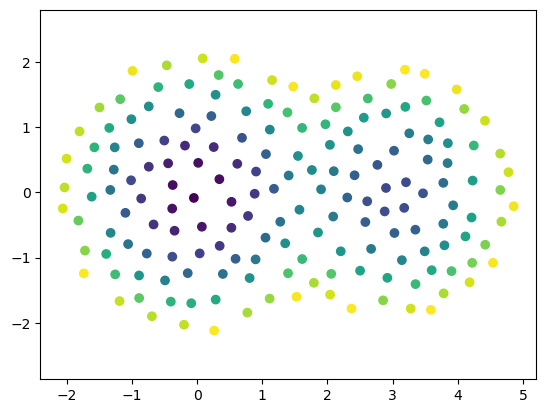

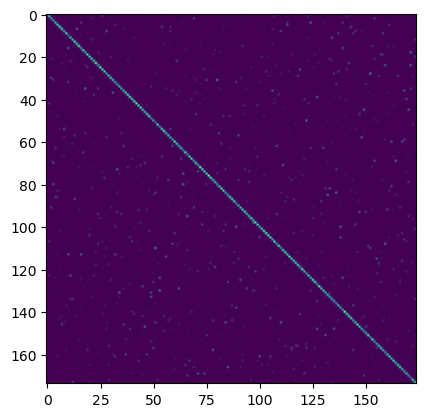

In [5]:
minima_coords = [[0,0],[3,0]] #[[1,-1],[0,0],[2,1],[-3,0]]
#minima_coords = [[1,-1,3],[0,0,0],[2,1,1],[-3,0,1]]
minima_energies = [[0,1],[1,1]] #[[1,0.9],[0,0.7],[1,0.5],[.5,1]]
state_density = 200
kT = .4
noise_spectrum = "TBD"
threshold = 0.01
min_spacing = 0.3

#find the average distance to the 7th or 8th nearest neighbor and use that as a threshold for MSM construction
#set the base timescale to be very short so that only the nearest neighbors matter and then multiply that MSM by itself to get a TPM for timescales of interest
#employ sparse matrices for efficient propagation

xi_all, pi_all, e_all, pi_all_out, box_min, box_max = build_landscape(2, minima_coords, minima_energies, state_density, kT, threshold, min_spacing, noise_spectrum)
plot_synthetic_landscapes(xi_all, pi_all, e_all, pi_all_out, box_min, box_max, minima_coords, False, True, False, True, True)
trm = synthetic_msm(xi_all, e_all, min_spacing, kT)

# print(max(e_all))
# print(min(e_all))
# print(np.exp(-(min(e_all)-max(e_all))/kT))

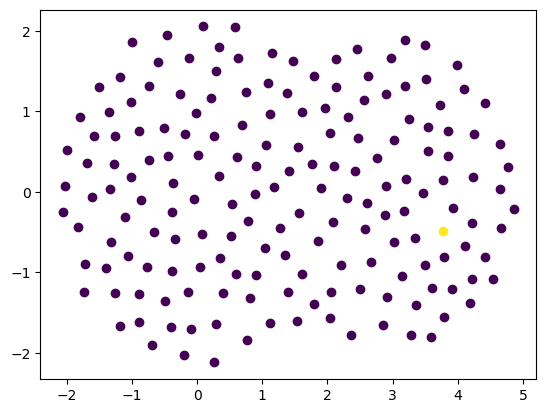

[[1.]]


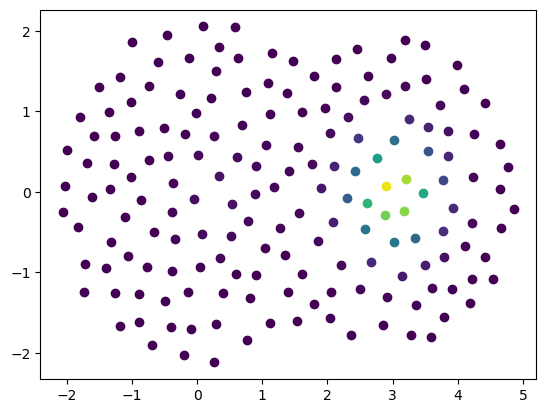

[[1.]]


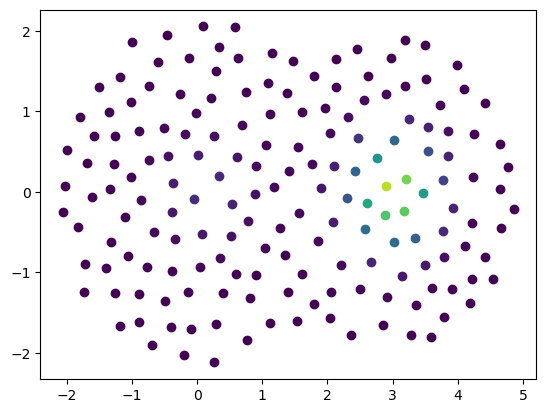

[[1.]]


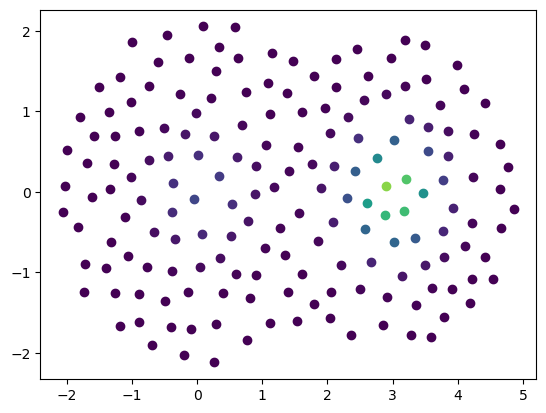

[[1.]]


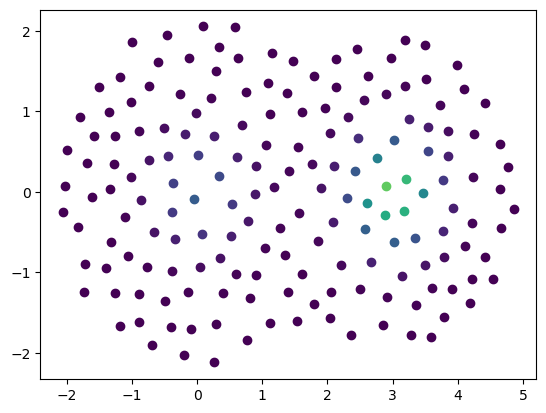

[[1.]]


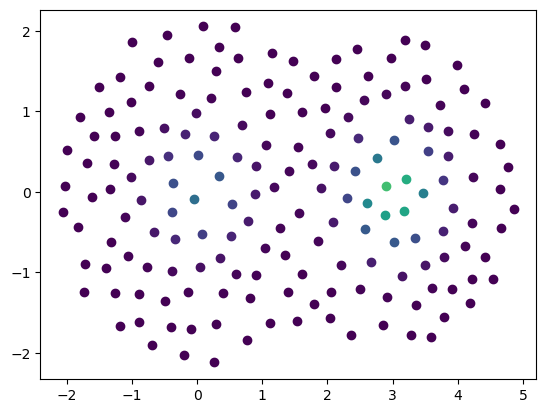

[[1.]]


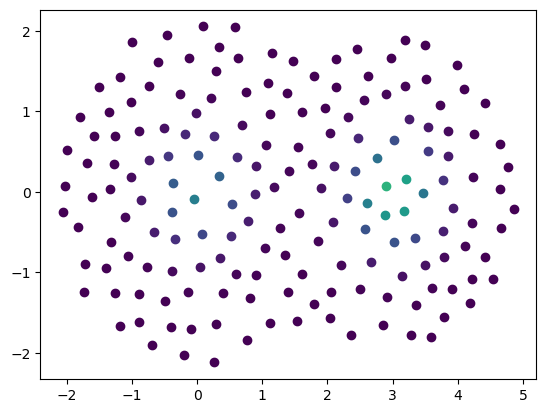

[[1.]]


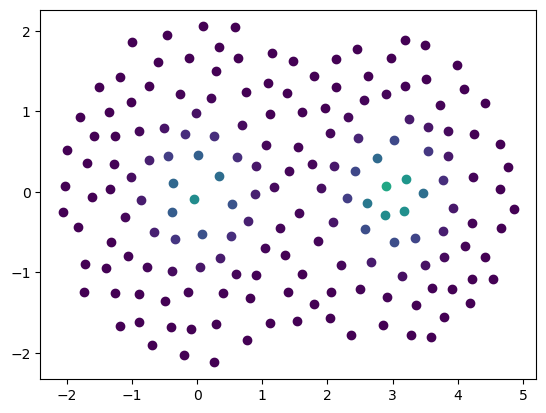

[[1.]]


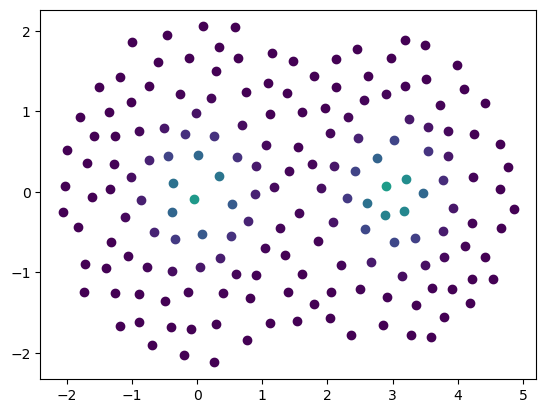

[[1.]]


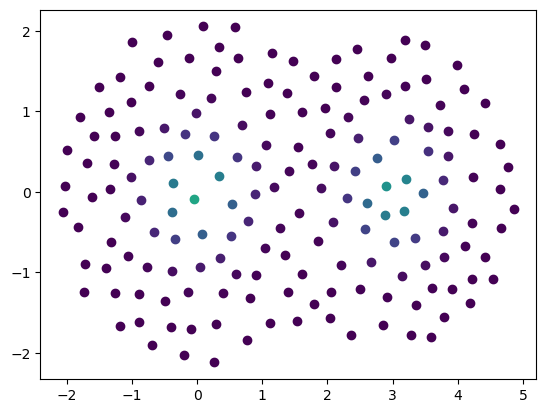

[[1.]]


In [6]:
init_state = np.zeros([trm.shape[0], 1])
init_state[0,0] = 1

state_t = init_state
for i in range(10):
    for si, s in enumerate(state_t):
        plt.scatter([xi_all[si][0]], [xi_all[si][1]], c=[s], cmap='viridis')
        plt.clim(0,.1)
    plt.show()
    state_t = np.matmul(np.matrix(trm)**100, state_t)
    print(sum(state_t))
